In [1]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array, hex_array
from hera_filters import dspec
from jax import numpy as jnp
from hera_cal import abscal, redcal, datacontainer
import time
import jax
from hera_sim import vis, utils
from stefcal import calibration
jax.config.update("jax_enable_x64", True)
%matplotlib notebook
%load_ext line_profiler

In [8]:
%%time
nfreqs = 100
freqs = np.linspace(50e6, 250e6, nfreqs)
ntimes = 10
timing = []

for i in range(30, 60):
    antpos = linear_array(i)
    reds = redcal.get_reds(antpos)

    gains = {
        (k, 'Jnn'): np.random.normal(1, 0.1, size=(1, nfreqs)) * np.exp(-1j * np.random.uniform(-np.pi, np.pi, (1, nfreqs)))
        for k in antpos
    }

    _gains, model_vis, data_vis = vis.sim_red_data(reds, shape=(1, nfreqs), gains=gains)
    model_vis = datacontainer.RedDataContainer(model_vis, reds=reds)
    data_vis = datacontainer.DataContainer(data_vis)
    wgts_dict = datacontainer.DataContainer({k: np.zeros(data_vis[k].shape, dtype=bool) for k in data_vis})
    
    _timing = []
    for j in range(ntimes):
        start = time.time()
        gains_stef, niter, conv_crit = calibration.sky_calibration(
            data_vis, model_vis, wgts_dict, maxiter=1000, tol=1e-10, stepsize=0.5
        )
        _timing.append(time.time() - start)
        
    timing.append(np.array(_timing))

/usr/local/anaconda3/lib/python3.8/site-packages/hera_sim/noise.py:243: UserWarning: white_noise is being deprecated. Use utils.gen_white_noise instead.
  warnings.warn("white_noise is being deprecated. Use utils.gen_white_noise instead.")


CPU times: user 19.6 s, sys: 196 ms, total: 19.8 s
Wall time: 19.8 s


In [9]:
from scipy import stats

In [10]:
mtime = np.median(timing, axis=1)
nA = np.arange(30, 60)

<IPython.core.display.Javascript object>


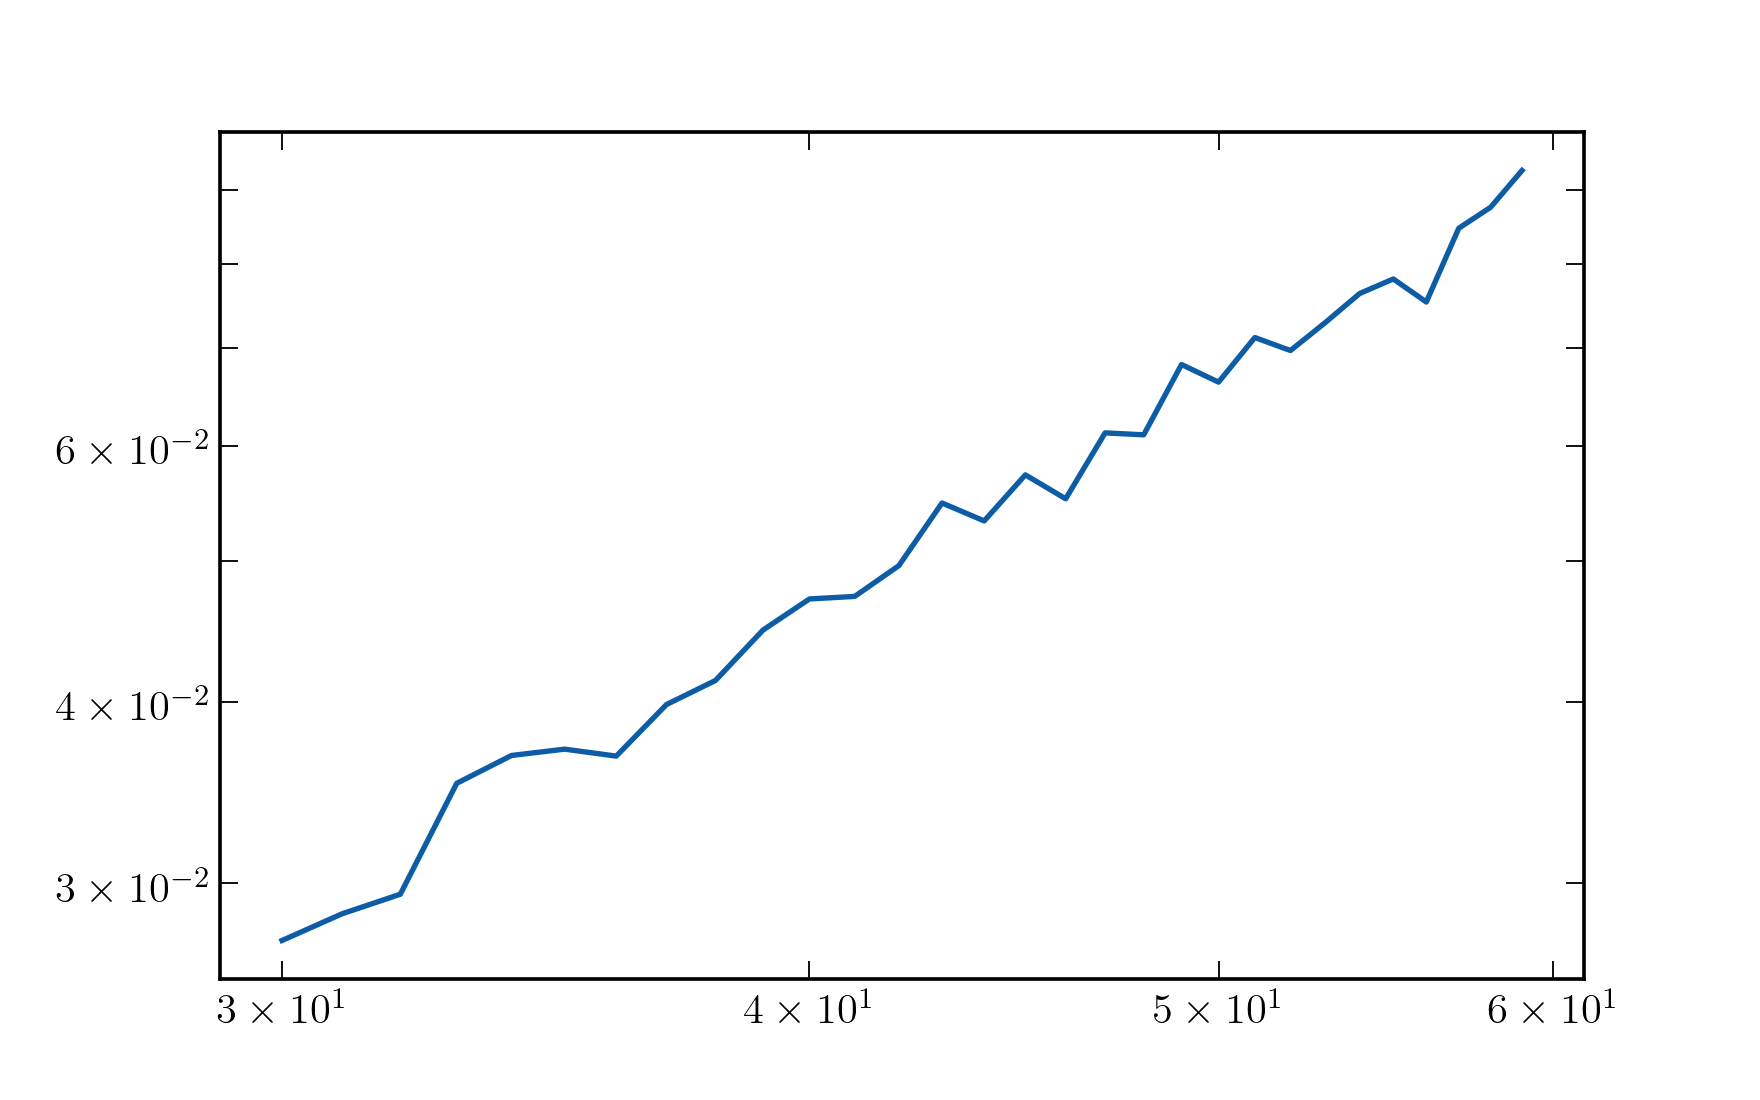

In [11]:
plt.figure()
plt.loglog(nA, np.median(timing, axis=1))
plt.show()

In [12]:
pfit = np.polyfit(np.log10(nA)[:], np.log10(mtime)[:], 1)
fit = 10 ** np.polyval(pfit, np.log10(nA))
pfit

array([ 1.71209542, -4.08219825])

<IPython.core.display.Javascript object>


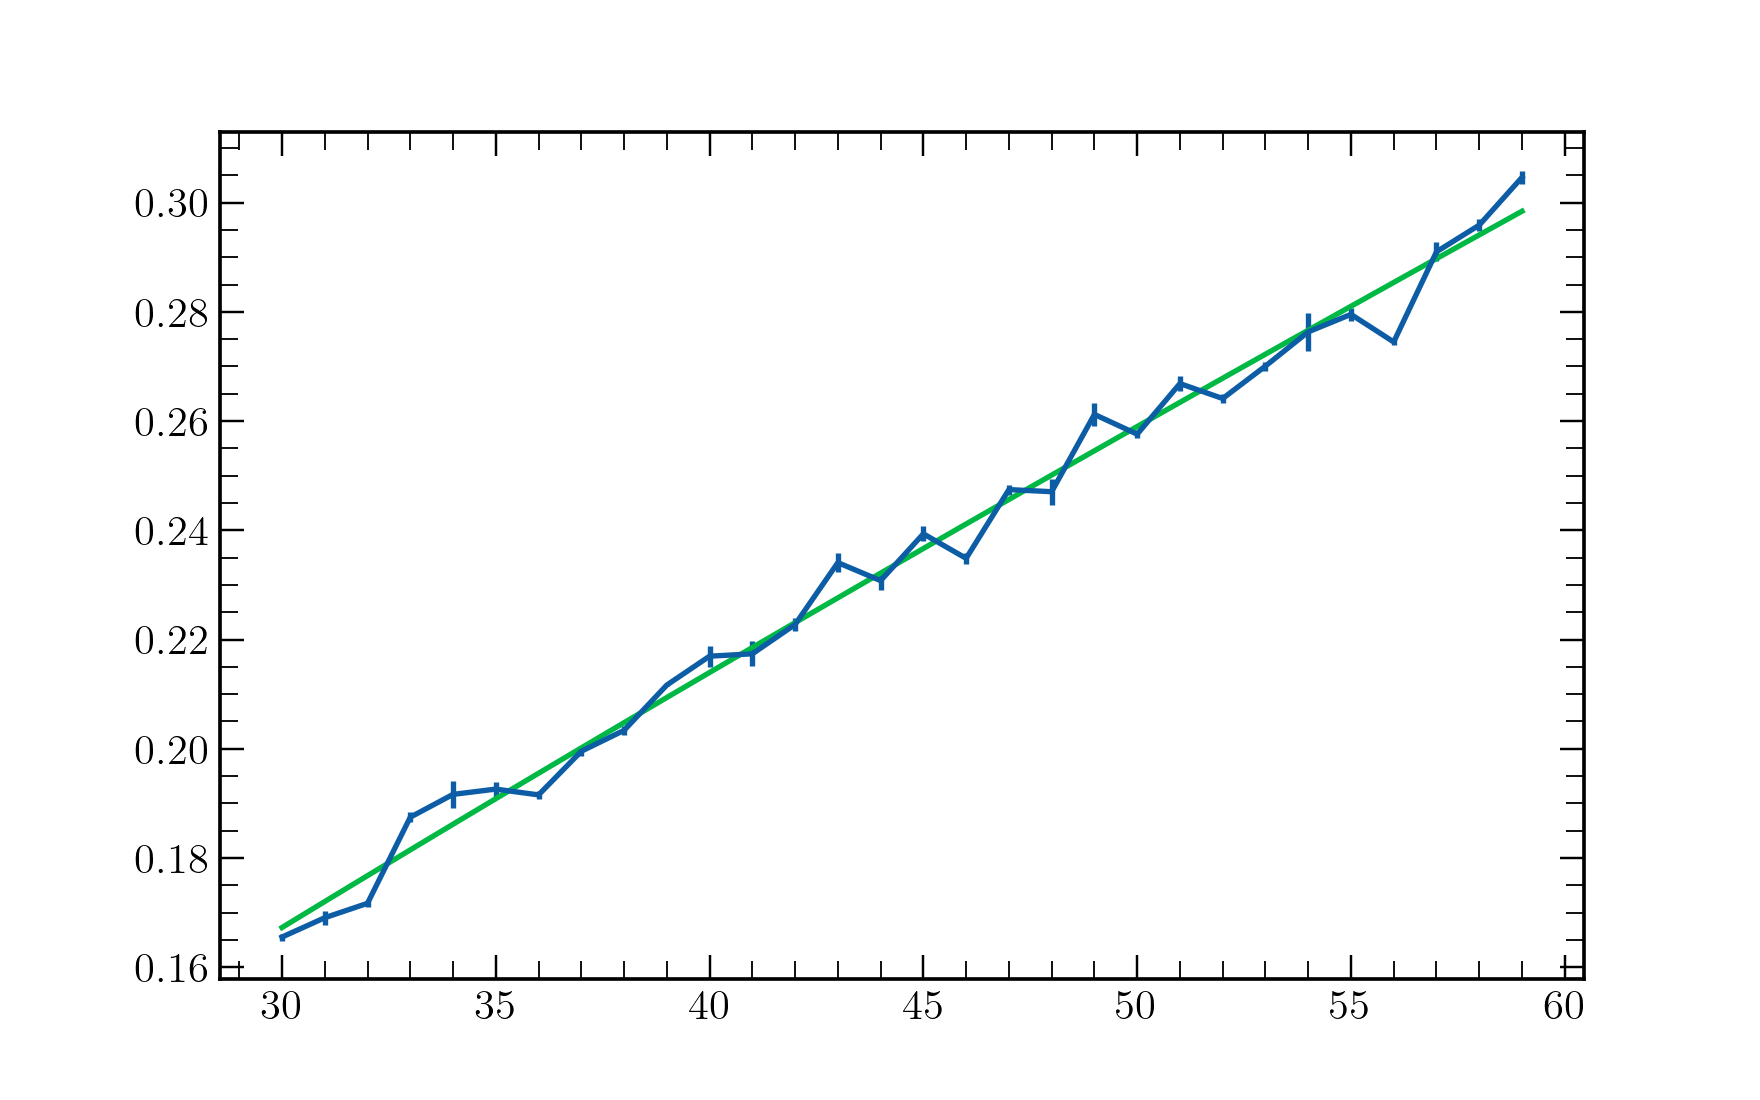

In [13]:
plt.figure()
plt.errorbar(nA, np.sqrt(np.median(timing, axis=1)), yerr=stats.median_abs_deviation(timing, axis=1))
plt.plot(nA, np.sqrt(fit))
plt.show()